## Our load FASTA function from last time

In [2]:
import gzip

def loadFasta(filename):
    """ Parses a classically formatted and possibly 
        compressed FASTA file into two lists. One of 
        headers and a second list of sequences.
        The ith index of each list correspond."""
    if (filename.endswith(".gz")):
        fp = gzip.open(filename, 'r')
    else:
        fp = open(filename, 'r')
    # split at headers
    data = fp.read().split('>')
    fp.close()
    # ignore whatever appears before the 1st header
    data.pop(0)     
    headers = []
    sequences = []
    for sequence in data:
        lines = sequence.split('\n')
        headers.append(lines.pop(0))
        # add an extra "+" to make string "1-referenced"
        sequences.append('+' + ''.join(lines))
    return (headers, sequences)

## A modification of the k-mer count method from last time
This version creates a list of the genome positions where each *k-mer* appears. The length of these lists are the same as the k-mer counts. We also merge the postions of each k-mer with its reverse complement using the key which is *lexigraghically* (alphabetical in our case) first. 

In [3]:
def kmerPositions(k, sequence):
    """ returns the position of all k-mers in sequence as a dictionary"""
    kmerPosition = {}
    for i in range(1,len(sequence)-k+1):
        kmer = sequence[i:i+k]
        kmerPosition[kmer] = kmerPosition.get(kmer,[])+[i]
    # combine kmers with their reverse complements
    pairPosition = {}
    for kmer, posList in kmerPosition.items():
        krev = ''.join([{'A':'T','C':'G','G':'C','T':'A'}[base] for base in reversed(kmer)])   # one-liner
        if (kmer < krev):
            pairPosition[kmer] = sorted(posList + kmerPosition.get(krev, []))
        elif (krev < kmer):
            pairPosition[krev] = sorted(kmerPosition.get(krev, []) + posList)
        else:
            pairPosition[kmer] = posList
    return pairPosition

## Get the genome from last time

In [10]:
header, seq = loadFasta("../random data/VibrioCholerae.fa")

for i in range(len(header)):
    print(header[i])
    print(len(seq[i])-1, "bases", seq[i][:30], "...", seq[i][-30:])
    print()

genome = seq[0]
OriCStart = 151887

gi|146313784|gb|CP000626.1| Vibrio cholerae O395 chromosome 1, complete genome
1108250 bases +ACAATGAGGTCACTATGTTCGAGCTCTTC ... CCGATAGTAGAGGTTTATACCATCGCAAAA

gi|147673035|ref|NC_009457.1| Vibrio cholerae O395 chromosome 2, complete genome
3024069 bases +GTTCGCCAGAGCGGTTTTTGACTAGCTTG ... TTTCTGGGTTAAACAGATACTCGGGGCTGG



## A *Clump* finding algorithm.

We define a *Lt-clump* of a string as a window of length *L* that contains *t* or more copies of any k-mer and it's reverse complement. Note, it calls kmerPositions() as a subroutine.

In [11]:
def findClumps(string, k, L, t):
    """ Find clumps of repeated k-mers in string. A clump occurs when t or more k-mers appear 
        within a window of size L. A list of (k-mer, position, count) tuples is returned """
    clumps = []
    kmerData = kmerPositions(k, string)
    for kmer, posList in kmerData.items():
        for start in range(len(posList)-t):
            end = start + t - 1
            while ((posList[end] - posList[start]) <= L-k):
                end += 1
                if (end >= len(posList)):
                    break
            if (end - start >= t):
                clumps.append((kmer, posList[start], end - start))
    return clumps

In [12]:
clumpList = findClumps(genome, 9, 500, 6)
print(len(clumpList))
print([clumpList[i] for i in range(min(20,len(clumpList)))])

172
[('ATCAAAAAT', 566252, 6), ('AACCAGAAC', 922082, 13), ('AACCAGAAC', 922088, 12), ('AACCAGAAC', 922094, 11), ('AACCAGAAC', 922100, 10), ('AACCAGAAC', 922106, 9), ('AACCAGAAC', 922112, 8), ('AACCAGAAC', 922118, 7), ('AACCAGAAC', 922124, 6), ('GCAATAACA', 704434, 6), ('ATGTTATTG', 704433, 6), ('AATAACATC', 704432, 6), ('CTCTCTCTC', 798535, 6), ('AAATCAAAA', 566247, 7), ('AAATCAAAA', 566254, 6), ('AACAGCAAC', 1073067, 21), ('AACAGCAAC', 1073073, 20), ('AACAGCAAC', 1073079, 19), ('AACAGCAAC', 1073085, 18), ('AACAGCAAC', 1073091, 17)]


## Now let's get back the positions of these clumps.
We focus on top-9 *biggest* clumps and seed the k-mer of the known ***Ori*** pattern 

In [13]:
# Lets get the positions of all k-mers again
kmers = kmerPositions(9, genome)

# find kmers appearing in the most clumps 
kmerClump = {}
for kmer,start,clumpSize in clumpList:
    kmerClump[kmer] = kmerClump.get(kmer,0) + 1
top10 = ['ATGATCAAG'] + [k for k in sorted(kmerClump, reverse=True, key=kmerClump.get)][:9]
print(top10)

['ATGATCAAG', 'ACAGCAACA', 'AACAGCAAC', 'CAACAGCAA', 'CAGCAACAG', 'GCAACAGCA', 'AGCAACAGC', 'CCAGAACCA', 'ACCAGAACC', 'GAACCAGAA']


## Let's look at where they are

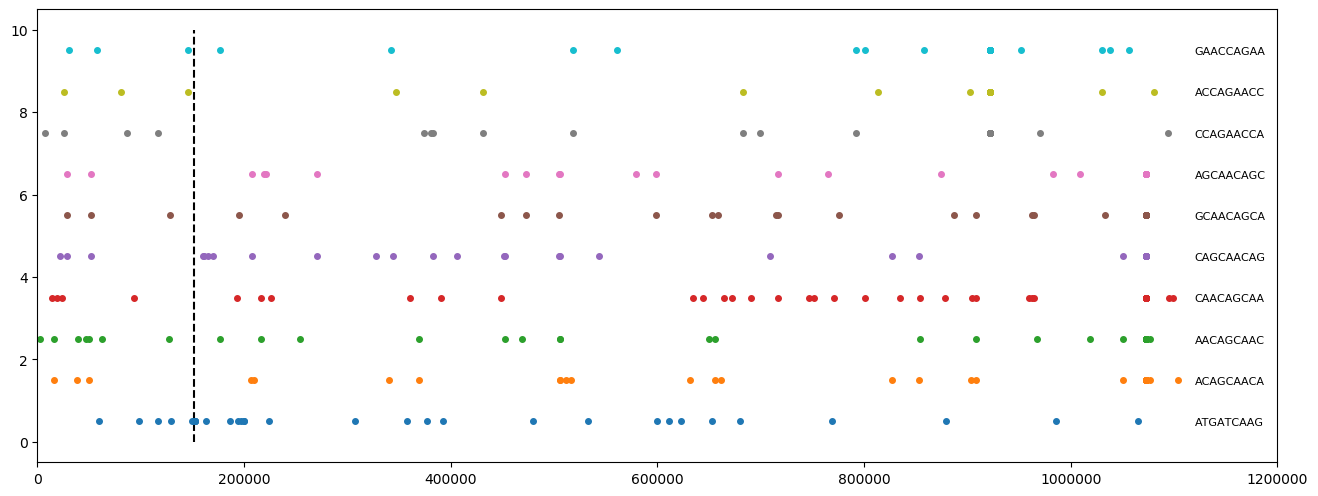

In [14]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.figure(num=None, figsize=(16, 6), dpi=100, facecolor='w', edgecolor='k')
plt.plot([OriCStart, OriCStart], [0,10], 'k--')
for n, kmer in enumerate(top10):
    positions = kmers[kmer]
    plt.text(1120000, n+0.4, kmer, fontsize=8)
    plt.plot(positions, [n + 0.5 for i in range(len(positions))], 'o', markersize=4.0)
limit = plt.xlim((0,1200000))

In [16]:
header, seq = loadFasta("../random data/ThermotogaPetrophila.fa")

for i in range(len(header)):
    print(header[i])
    print(len(seq[i])-1, "bases", seq[i][:30], "...", seq[i][-30:])
    print()

oriCStart = 786686
oriOffset = 211          # offset to the middle of OriC

x = seq[0][oriCStart+oriOffset-50:oriCStart+oriOffset+50]
y = ''.join({'A':'T', 'C':'G', 'G':'C', 'T':'A'}[b] for b in x)
print(x[:50],x[50:])
print(y[:50],y[50:])

CP000702.1 Thermotoga petrophila RKU-1, complete genome
1823511 bases +AGTTGGACGAAGGTTCTGATCCCTACAGA ... TCAATGTTATAATAAATACCGTGCAAAAAC

GGAATTGAATATATGCAAAACAAACCTACCACCAAACTCTGTATTGACCA TTTTAGGACAACTTCAGGGTGGTAGGTTTCTGAAGCTCTCATCAATAGAC
CCTTAACTTATATACGTTTTGTTTGGATGGTGGTTTGAGACATAACTGGT AAAATCCTGTTGAAGTCCCACCATCCAAAGACTTCGAGAGTAGTTATCTG


In [17]:
def getStats(sequence, start):
    halflen = len(sequence)//2
    terC = start + halflen
    # handle genome's circular nature
    if (terC > len(sequence)):
        terC = terC - len(sequence) + 1
    stats = {}
    for base in "ACGT":
        total = sequence.count(base)
        if (terC > start):                                   # case 1: ----S========T---->
            forwardCount = sequence[start:terC].count(base)
            reverseCount = total - forwardCount
        else:                                                # case 2: ====T--------S====>
            reverseCount = sequence[terC:start].count(base)
            forwardCount = total - reverseCount
        stats[base] = (total, forwardCount, reverseCount)
    return stats

answer = getStats(seq[0], oriCStart+oriOffset)
for base in "CGAT":
    total, forwardCount, reverseCount = answer[base]
    print("%s: %8d %8d %8d %8d" % (base,total,forwardCount,reverseCount,forwardCount-reverseCount))

C:   427419   207901   219518   -11617
G:   413241   211607   201634     9973
A:   491488   247525   243963     3562
T:   491363   244723   246640    -1917


In [18]:
def getGCdiff(sequence, start):
    halflen = len(sequence)//2
    terC = start + halflen
    # handle genome's circular nature
    if (terC > len(sequence)):
        terC = terC - len(sequence) + 1
    if (terC > start):                                   # case 1: ----S========T---->
        G = 2*sequence[start:terC].count('G') - sequence.count('G')
        C = 2*sequence[start:terC].count('C') - sequence.count('C')
    else:                                                # case 2: ====T--------S====>
        G = sequence.count('G') - 2*sequence[terC:start].count('G')
        C = sequence.count('C') - 2*sequence[terC:start].count('C')
    return G - C

def GCSkew(genome):
    x = []
    y = []
    for i in range(1,len(genome),500):
        x.append(i)
        y.append(getGCdiff(genome,i))
    return x, y

786001 21602


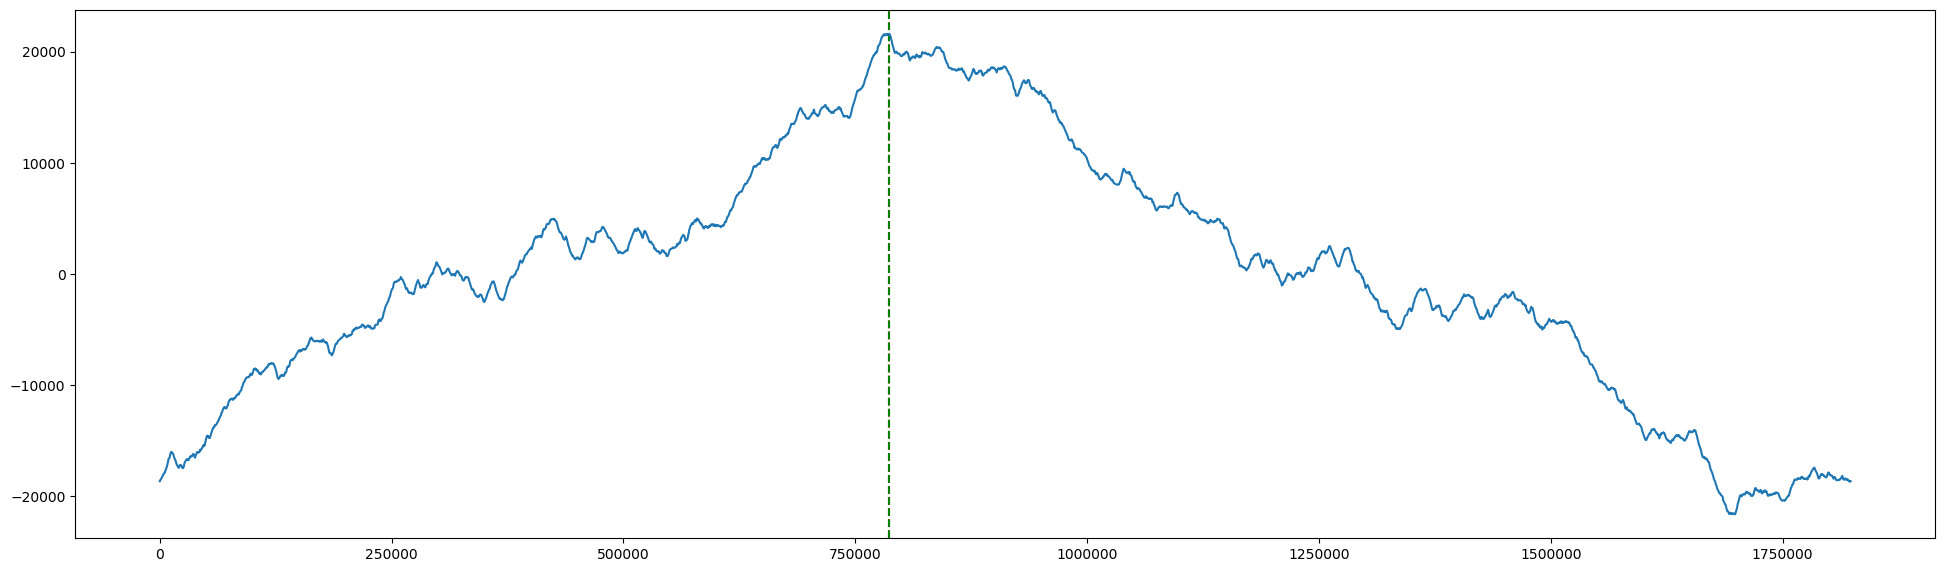

In [19]:
x, y = GCSkew(seq[0])

plt.figure(num=None, figsize=(24, 7), dpi=100)
yargmax = y.index(max(y))
plt.axvline(oriCStart+oriOffset, color="r", linestyle='--')
plt.axvline(x[yargmax], color="g", linestyle='--')
result = plt.plot(x, y)
print(x[yargmax], y[yargmax])

In [ ]:
header, seq = loadFasta("data/VibrioCholerae.fa")
oriCStart = 151887
x, y = GCSkew(seq[0])
yargmax = y.index(max(y))
plt.figure(num=None, figsize=(24, 7), dpi=100)
plt.axvline(oriCStart, color="r", linestyle='--')
plt.axvline(x[yargmax], color="g", linestyle='--')
result = plt.plot(x, y)
print(x[yargmax], y[yargmax])

In [ ]:
header, seq = loadFasta("data/EscherichiaColi.fa")

for i in range(len(header)):
    print(header[i])
    print(len(seq[i])-1, "bases", seq[i][:30], "...", seq[i][-30:])
    print()

In [ ]:
x, y = GCSkew(seq[0])
yargmax = y.index(max(y))
plt.figure(num=None, figsize=(24, 7), dpi=100)
plt.axvline(x[yargmax], color="g", linestyle='--')
result = plt.plot(x, y)
print(x[yargmax], y[yargmax])